In [8]:
import pandas as pd
import pyodbc
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text
from sqlalchemy import create_engine
from langdetect import detect, DetectorFactory

# Ensure reproducibility for langdetect
DetectorFactory.seed = 0


In [9]:
# --- Configuration ---
server_name = r"YASSINE\SQLEXPRESS"  # Your SQL Server instance
mdf_file = r"D:\SQLData\AirbnbDataWarehouse.mdf"  # Path to your .mdf
db_name = "AirbnbDataWarehouse"  # Logical database name

# --- Connection string for pyodbc ---
# Using Trusted Connection (Windows authentication)
conn_str = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server_name};"
    f"Trusted_Connection=yes;"
    f"AttachDbFilename={mdf_file};"
    f"DATABASE={db_name};"
)

# --- Attempt connection ---
try:
    cnxn = pyodbc.connect(conn_str)
    print("✅ Successfully connected to the database.")
except pyodbc.Error as ex:
    print("❌ Error connecting to the database:")
    print(ex)
    print("Check that SQL Server is running, the ODBC driver is installed,")
    print("and that the .mdf file is accessible and not already attached.")
    cnxn = None

# --- Create SQLAlchemy engine for pandas or other libraries ---
if cnxn:
    # URL-encode the connection string for SQLAlchemy
    params = urllib.parse.quote_plus(conn_str)
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
    print("✅ SQLAlchemy engine created successfully.")
else:
    engine = None
    print("⚠️ SQLAlchemy engine not created due to connection error.")

# --- Optional: Verify connection by fetching top 5 tables (example) ---
if engine:
    try:
        with engine.connect() as connection:
            result = connection.execute(text("SELECT name FROM sys.tables;"))
            tables = [row[0] for row in result]
            print("Tables in database:", tables)  # print full list
    except Exception as e:
        print("⚠️ Could not fetch tables:", e)

✅ Successfully connected to the database.
✅ SQLAlchemy engine created successfully.
Tables in database: ['dim_listings', 'dim_listing_id_map', 'dim_listings_staging', 'fact_calendar_temp', 'fact_reviews_temp', 'dim_hosts', 'dim_dates', 'fact_calendar', 'fact_reviews']


In [10]:
# --- List Tables in the Database ---
if cnxn:
    try:
        cursor = cnxn.cursor()
        cursor.execute("SELECT TABLE_SCHEMA, TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")
        tables = cursor.fetchall()
        print("Tables in the database:")
        for table in tables:
            print(f"- {table[0]}.{table[1]}")
    except Exception as e:
        print(f"Error listing tables: {e}")
else:
    print("Cannot list tables: Database connection not established.")

Tables in the database:
- dbo.dim_listings
- dbo.dim_listing_id_map
- dbo.dim_listings_staging
- dbo.fact_calendar_temp
- dbo.fact_reviews_temp
- dbo.dim_hosts
- dbo.dim_dates
- dbo.fact_calendar
- dbo.fact_reviews


## 1. Data Loading

In [11]:
# Load necessary tables into pandas DataFrames
try:
    df_hosts = pd.read_sql('SELECT * FROM dim_hosts', engine)
    df_reviews = pd.read_sql('SELECT * FROM fact_reviews', engine)
    df_listings = pd.read_sql('SELECT * FROM dim_listings', engine)
    print("DataFrames loaded successfully: df_hosts, df_reviews, df_listings")
except Exception as e:
    print(f"Error loading data: {e}")

print("--- df_hosts Info ---")
df_hosts.info()
print("--- df_reviews Info ---")
df_reviews.info()
print("--- df_listings Info ---")
df_listings.info()


DataFrames loaded successfully: df_hosts, df_reviews, df_listings
--- df_hosts Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740651 entries, 0 to 740650
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   host_id         740651 non-null  int64         
 1   host_name       733538 non-null  object        
 2   host_city       740651 non-null  object        
 3   host_country    740651 non-null  object        
 4   total_listings  740651 non-null  int64         
 5   created_date    740651 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 33.9+ MB
--- df_reviews Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6357239 entries, 0 to 6357238
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   review_id      int64 
 1   listing_id     int64 
 2   date_id        int64 
 3   reviewer_id    int64 
 4   revie

## 2. Null Value Examination

--- Null Values in df_hosts ---
           Null Count  Null Percentage
host_name        7113         0.960371


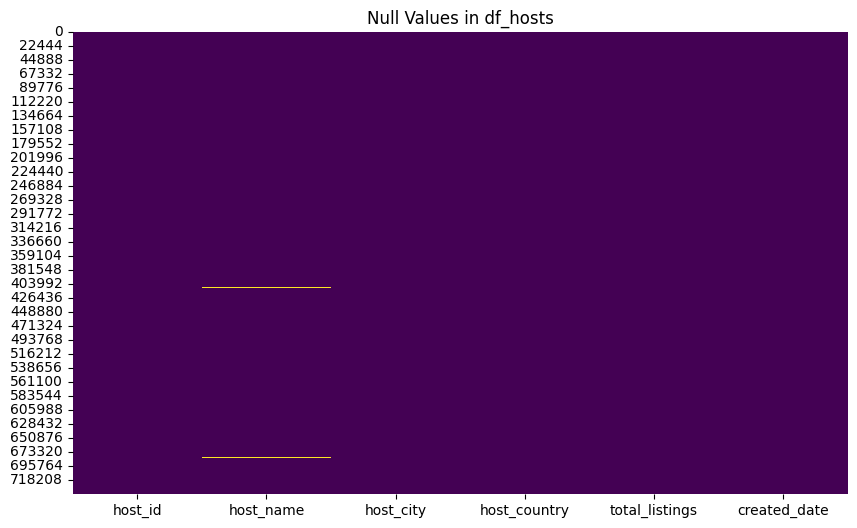

--- Null Values in df_reviews ---
               Null Count  Null Percentage
reviewer_name          17         0.000267


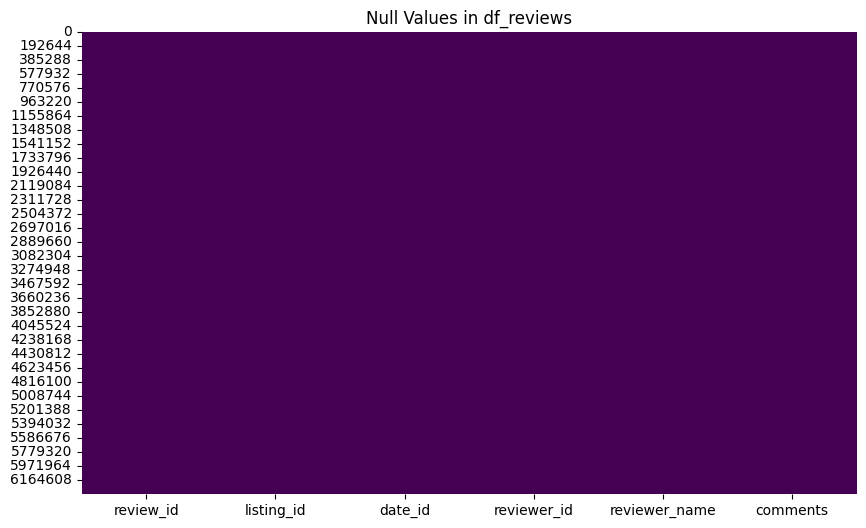

--- Null Values in df_listings ---
                        Null Count  Null Percentage
is_local_host              1494030       100.000000
review_scores_rating        302617        20.255082
price                       251406        16.827373
host_name                    19092         1.277886
property_neighbourhood        1078         0.072154
longitude                       21         0.001406


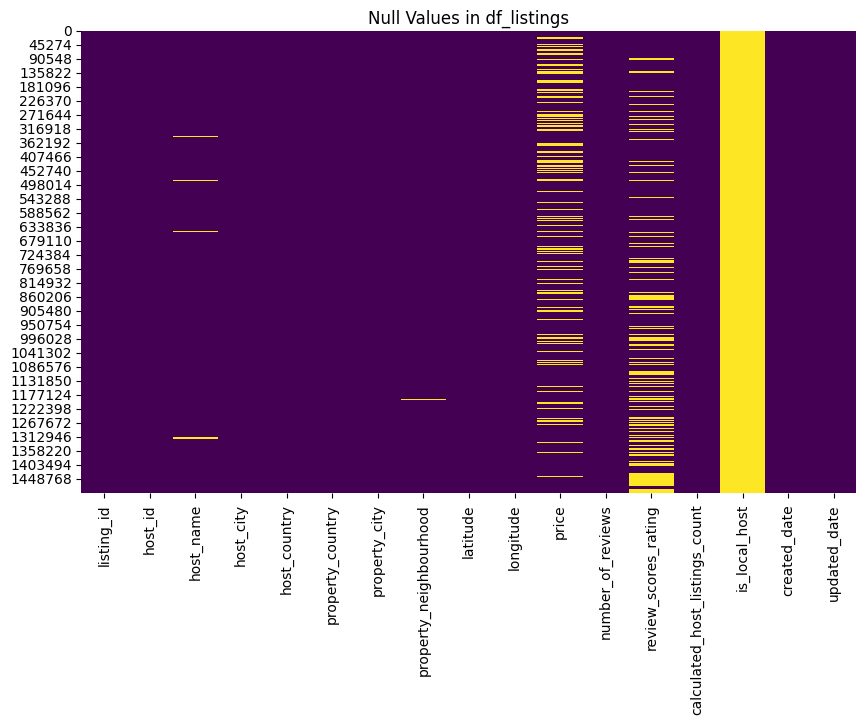

In [12]:
def check_null_values(df, df_name):
    print(f"--- Null Values in {df_name} ---")
    null_counts = df.isnull().sum()
    null_percentages = (df.isnull().sum() / len(df)) * 100
    null_info = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percentages})
    null_info = null_info[null_info['Null Count'] > 0].sort_values(by='Null Percentage', ascending=False)
    print(null_info)

    if not null_info.empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
        plt.title(f'Null Values in {df_name}')
        plt.show()
    else:
        print(f"No null values found in {df_name}.")

check_null_values(df_hosts, 'df_hosts')
check_null_values(df_reviews, 'df_reviews')
check_null_values(df_listings, 'df_listings')


## 3. "Unknown" Value Examination

--- 'Unknown' Values in df_hosts ---
host_city       213874
host_country    198302
host_name         7115
dtype: int64


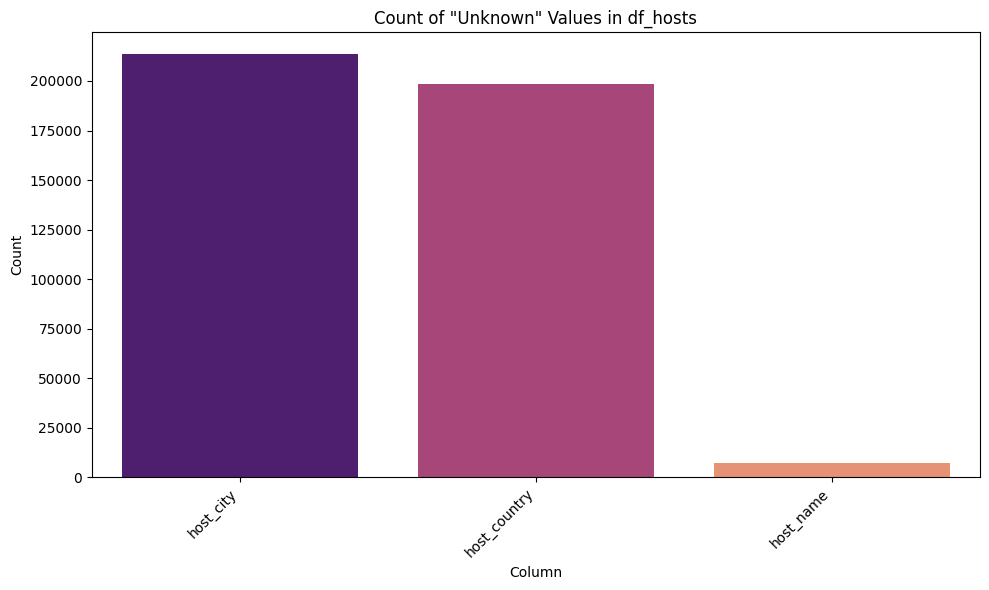

--- 'Unknown' Values in df_reviews ---
reviewer_name    21
dtype: int64


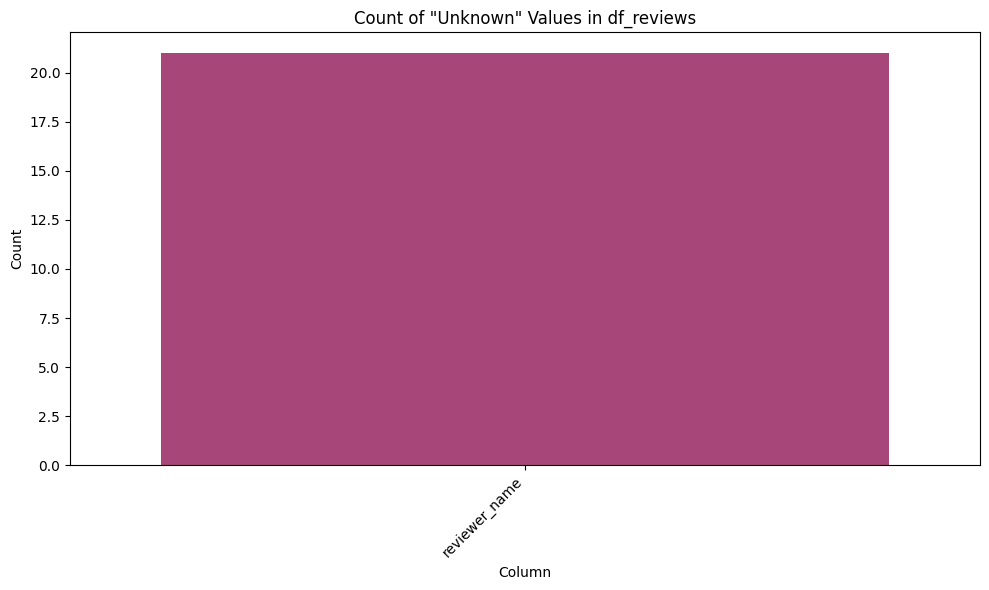

--- 'Unknown' Values in df_listings ---
is_local_host             1494030
host_city                  439348
host_country               399009
property_neighbourhood      94400
host_name                   19094
dtype: int64


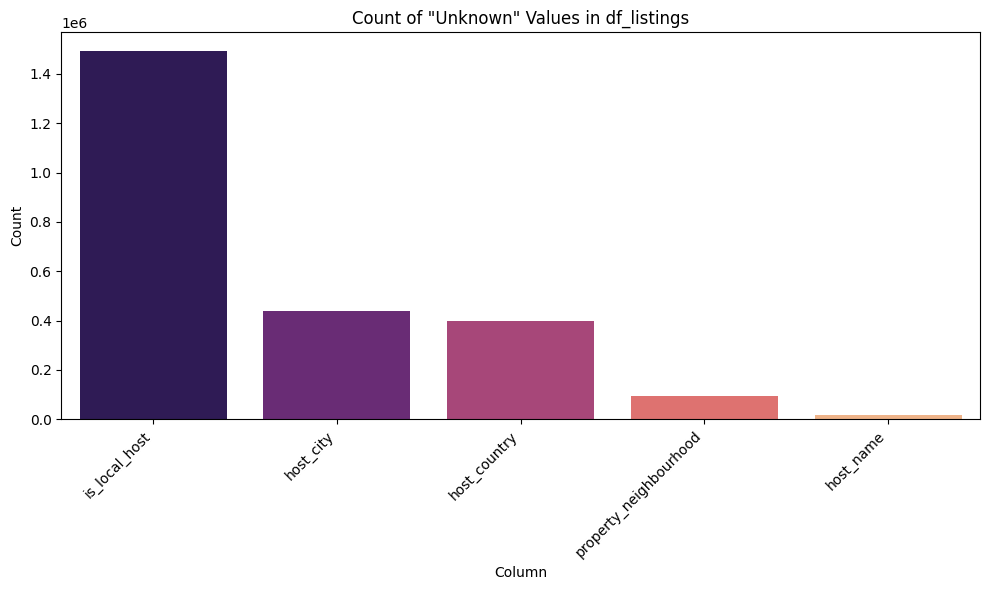

In [13]:
def check_unknown_values(df, df_name, unknown_values=['unknown', 'n/a', '-', 'none', '', 'null', 'not available']):
    print(f"--- 'Unknown' Values in {df_name} ---")
    unknown_counts = {}
    for col in df.select_dtypes(include='object').columns:
        # Convert to string to handle mixed types gracefully
        col_series = df[col].astype(str).str.lower()
        count = col_series.isin(unknown_values).sum()
        if count > 0:
            unknown_counts[col] = count
    
    if unknown_counts:
        unknown_info = pd.Series(unknown_counts).sort_values(ascending=False)
        print(unknown_info)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=unknown_info.index, y=unknown_info.values, hue=unknown_info.index, palette='magma', legend=False)
        plt.title(f'Count of "Unknown" Values in {df_name}')
        plt.ylabel('Count')
        plt.xlabel('Column')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No common 'unknown' values found in string columns of {df_name}.")

check_unknown_values(df_hosts, 'df_hosts')
check_unknown_values(df_reviews, 'df_reviews')
check_unknown_values(df_listings, 'df_listings')


## 4. Correlation Analysis

--- Correlation Matrix for df_listings (Numeric Columns) ---
                                listing_id   host_id  latitude  longitude  \
listing_id                        1.000000  0.469025 -0.024637   0.027701   
host_id                           0.469025  1.000000  0.024365   0.032566   
latitude                         -0.024637  0.024365  1.000000  -0.394398   
longitude                         0.027701  0.032566 -0.394398   1.000000   
price                             0.002101  0.000545 -0.026872  -0.007386   
number_of_reviews                -0.349603 -0.184884 -0.009855  -0.009704   
review_scores_rating             -0.045612 -0.083092 -0.036061  -0.017479   
calculated_host_listings_count    0.063522 -0.033228 -0.019533   0.009148   

                                   price  number_of_reviews  \
listing_id                      0.002101          -0.349603   
host_id                         0.000545          -0.184884   
latitude                       -0.026872          -0.009

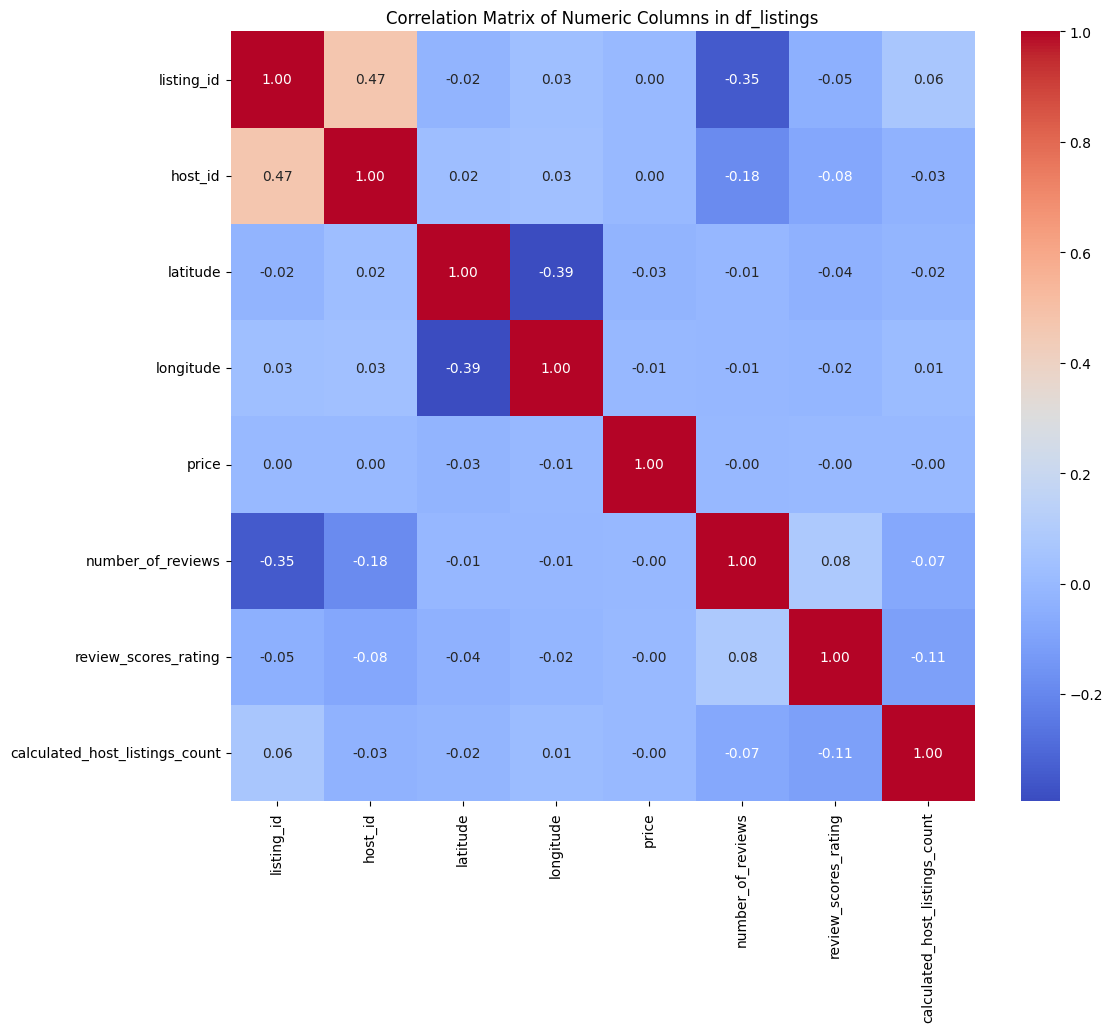

In [14]:
# Select only numeric columns for correlation analysis
numeric_df_listings = df_listings.select_dtypes(include=['number'])

if not numeric_df_listings.empty:
    correlation_matrix = numeric_df_listings.corr()
    print("--- Correlation Matrix for df_listings (Numeric Columns) ---")
    print(correlation_matrix)

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numeric Columns in df_listings')
    plt.show()
else:
    print("No numeric columns found in df_listings for correlation analysis.")

## 5. Language Detection in Reviews

In [ ]:
# Function to safely detect language
def safe_detect_language(text):
    try:
        return detect(str(text))
    except:
        return 'unknown'

# Apply language detection to review comments
# Ensure 'comments' column exists and is not entirely null
if 'comments' in df_reviews.columns and not df_reviews['comments'].isnull().all():
    df_reviews['language'] = df_reviews['comments'].apply(safe_detect_language)
    
    print("--- Distinct Languages in Reviews ---")
    language_counts = df_reviews['language'].value_counts()
    print(language_counts)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')
    plt.title('Distribution of Languages in Reviews')
    plt.xlabel('Language')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Percentage of foreign language use in reviews for a particular city (e.g., Paris)
    # Assuming 'city' column exists in df_listings and 'listing_id' for joining
    # Merge reviews with listings to get city information
    if 'listing_id' in df_reviews.columns and 'listing_id' in df_listings.columns and 'city' in df_listings.columns:
        df_reviews_with_city = pd.merge(df_reviews, df_listings[['listing_id', 'city']], on='listing_id', how='left')
        
        target_city = 'Paris' # Example city
        target_country_language = 'fr' # French for Paris

        paris_reviews = df_reviews_with_city[df_reviews_with_city['city'].str.contains(target_city, case=False, na=False)]

        if not paris_reviews.empty:
            total_paris_reviews = len(paris_reviews)
            foreign_paris_reviews = paris_reviews[paris_reviews['language'] != target_country_language]
            num_foreign_paris_reviews = len(foreign_paris_reviews)
            
            if total_paris_reviews > 0:
                percentage_foreign = (num_foreign_paris_reviews / total_paris_reviews) * 100
                print(f"--- Foreign Language Use in {target_city} Reviews ---")
                print(f"Total reviews in {target_city}: {total_paris_reviews}")
                print(f"Reviews in languages other than {target_country_language} in {target_city}: {num_foreign_paris_reviews}")
                print(f"Percentage of foreign language reviews in {target_city}: {percentage_foreign:.2f}%")
            else:
                print(f"No reviews found for {target_city}.")
        else:
            print(f"No listings found for {target_city} to analyze reviews.")
    else:
        print("Required columns (listing_id, city, comments) not found for language analysis.")
else:
    print("'comments' column not found or is empty in df_reviews, skipping language detection.")

## 6. Host Country Correction

In [ ]:
# Note the issue: US state abbreviations in 'host_country' column
print("--- Original 'host_country' values in df_hosts (first 20 unique) ---")
print(df_hosts['host_country'].value_counts().head(20))

# Define a mapping for US state abbreviations to 'United States'
us_states = {
    'AL': 'United States', 'AK': 'United States', 'AZ': 'United States', 'AR': 'United States',
    'CA': 'United States', 'CO': 'United States', 'CT': 'United States', 'DE': 'United States',
    'FL': 'United States', 'GA': 'United States', 'HI': 'United States', 'ID': 'United States',
    'IL': 'United States', 'IN': 'United States', 'IA': 'United States', 'KS': 'United States',
    'KY': 'United States', 'LA': 'United States', 'ME': 'United States', 'MD': 'United States',
    'MA': 'United States', 'MI': 'United States', 'MN': 'United States', 'MS': 'United States',
    'MO': 'United States', 'MT': 'United States', 'NE': 'United States', 'NV': 'United States',
    'NH': 'United States', 'NJ': 'United States', 'NM': 'United States', 'NY': 'United States',
    'NC': 'United States', 'ND': 'United States', 'OH': 'United States', 'OK': 'United States',
    'OR': 'United States', 'PA': 'United States', 'RI': 'United States', 'SC': 'United States',
    'SD': 'United States', 'TN': 'United States', 'TX': 'United States', 'UT': 'United States',
    'VT': 'United States', 'VA': 'United States', 'WA': 'United States', 'WV': 'United States',
    'WI': 'United States', 'WY': 'United States', 'DC': 'United States'
}

# Create 'corrected_country' column
df_hosts['corrected_country'] = df_hosts['host_country'].replace(us_states)

# Also handle cases where 'United States' might be written differently
df_hosts['corrected_country'] = df_hosts['corrected_country'].replace({'USA': 'United States', 'U.S.A.': 'United States', 'US': 'United States'})

print("--- 'corrected_country' values in df_hosts (first 20 unique) ---")
print(df_hosts['corrected_country'].value_counts().head(20))

# Display changes (example for a few rows)
print("--- Sample of host_country vs. corrected_country ---")
print(df_hosts[['host_country', 'corrected_country']].drop_duplicates().head(10))

## 7. Distinct Value Check and Standardization

In [ ]:
def check_and_standardize_column(df, column_name, df_name, threshold=20):
    if column_name in df.columns and df[column_name].dtype == 'object':
        print(f"--- Distinct Values for '{column_name}' in {df_name} ---")
        unique_values = df[column_name].value_counts()
        print(f"Total unique values: {len(unique_values)}")
        print(unique_values.head(threshold))

        if len(unique_values) > threshold:
            print(f"... (showing top {threshold} out of {len(unique_values)} unique values)")

        # Example of potential standardization (can be expanded)
        # For instance, if 'United States' and 'USA' are both present, standardize them.
        # This is already partially handled for 'host_country' above.
        # For other columns, manual inspection and mapping might be needed.
        
        # Visualization for top distinct values
        if len(unique_values) > 1:
            plt.figure(figsize=(12, 7))
            sns.barplot(x=unique_values.head(threshold).index, y=unique_values.head(threshold).values, palette='coolwarm')
            plt.title(f'Top {threshold} Distinct Values in {column_name} ({df_name})')
            plt.xlabel(column_name)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print(f"Column '{column_name}' not found or is not of object type in {df_name}.")

# Example columns to check for distinct values and potential standardization
check_and_standardize_column(df_hosts, 'host_country', 'df_hosts')
check_and_standardize_column(df_hosts, 'host_response_time', 'df_hosts')
check_and_standardize_column(df_listings, 'property_type', 'df_listings')
check_and_standardize_column(df_listings, 'room_type', 'df_listings')
check_and_standardize_column(df_listings, 'bed_type', 'df_listings')
check_and_standardize_column(df_listings, 'cancellation_policy', 'df_listings')

## 8. Additional Recommended Analysis

In [ ]:
print("--- Additional Analysis Recommendations ---")
print("1. **Time-Series Analysis:** Analyze trends in listings, prices, and reviews over time using `fact_calendar` and `dim_dates`.")
print("2. **Geospatial Analysis:** Visualize listings on a map to identify popular areas and price distributions (requires latitude/longitude data, likely in `dim_listings`).")
print("3. **Price Determinants:** Build a regression model to understand factors influencing listing prices (e.g., `accommodates`, `bedrooms`, `bathrooms`, `property_type`, `amenities`).")
print("4. **Host Behavior Analysis:** Examine host response rates, acceptance rates, and superhost status to understand their impact on listing performance.")
print("5. **Sentiment Analysis of Reviews:** Beyond language detection, perform sentiment analysis on review comments to gauge guest satisfaction.")
print("6. **Availability Analysis:** Investigate listing availability patterns and their correlation with pricing and demand.")